# Declaration

The code for all the model classifiers have been written from scratch. The Author of the code is <b>Vaibhav Khandelwal (me)</b>.

Following models have been developed to deal with real data and to handle real classifiers:
<ol>
    <li><b>Random Forest Classifier</b></li>
    <li><b>Adaboost</b></li>
    <li><b>Borda Voting</b></li>
    <li><b>Stacked Generalization</b></li>
    <li><b>Learn++ (Random Subspace Ensemble)- Single model classifier</b></li>
    <li><b>Learn++ (Random Subspace Ensemble)- Random model selection for classification</b></li>
    <li><b>Combination of Learn++ and Borda Voting</b></li>
    <li><b>Combination of Learn++ and Stacked Generalization</b></li>
</ol>

The description of the method and the results can be viewed from the report

# Importing Libraries

In [1]:
import sys
import pandas as pd
import numpy as np
import random
import math
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
# For time calculation
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Dataset Shapes (Will be used for futher)

In [2]:
data_names = ['spambase.csv', 'Iris.csv', 'StudentResult.csv', 'PokemonData.csv', 'NBA.csv']
for i in data_names:
  data_path = 'Data/' + i
  df = pd.read_csv(data_path)
  print(i, df.shape) 


spambase.csv (4601, 59)
Iris.csv (100, 6)
StudentResult.csv (395, 30)
PokemonData.csv (684, 35)
NBA.csv (1329, 21)


# 1) Random Forest Classifier

In [3]:
# ====== DECISION TREE IMPLEMENTATION FROM SCRATCH  =====

# Data Purity Check
# Input is dataframe Target column
def data_purity_check(target_col):
    # When only one class is available for classification
    if len(set(target_col)) == 1:
        return True
    # When several classes are there for classification
    else:
        return False
    
# Classify
# Input is dataframe itself
def classification(cf):
    target_col = cf.label.values
    list_of_count_of_target = list(Counter(target_col).items())
    sorted_list_of_count_of_target = sorted(list_of_count_of_target, key=lambda x: x[1])
    result_class = sorted_list_of_count_of_target[-1][0]
    return(result_class)

# Potential SPlits
# Input is dataframe itself
def find_potential_splits(fps_df):
    partition_box = dict()
    for col in fps_df.columns[:-1]: # Not including label column
        # Finding the partition corresponding to each feature
        unique_sorted_values_each_col = sorted(list(set(fps_df[col].values)))
        
        # Check for Continuous Variable
        if (fps_df[col].dtype.name in ['int', 'float', 'int64', 'float64']):
            # Finding the mid point between each sorted unique values in per column
            temp = [(unique_sorted_values_each_col[i] + unique_sorted_values_each_col[i-1])/2 for i in range(1, len(unique_sorted_values_each_col))]
        
        # Check for Categorical Variable
        elif (fps_df[col].dtype.name in ['object', 'category', 'bool', 'boolean']): 
            temp = unique_sorted_values_each_col
        
        # storing  the mid values list corresponding to each key (here column name)
        partition_box[col] = temp
    return partition_box

# Splitting the data
# Column is selected first and then the value at which split is to be done
# Input is dataframe itself, splitting column, splitting point
# It will return all the points on either side of the split line
def splitting(s_df, col_of_split, point_of_split):
    
    # For Continuous Variable
    if s_df[col_of_split].dtype.name in ['int', 'float', 'int64', 'float64']:
        left_part_of_split = s_df[s_df[col_of_split] <= point_of_split]
        right_part_of_split = s_df[s_df[col_of_split] > point_of_split]
    # For Categorical Variable
    elif s_df[col_of_split].dtype.name in ['object', 'category', 'bool', 'boolean']:
        left_part_of_split = s_df[s_df[col_of_split] == point_of_split]
        right_part_of_split = s_df[s_df[col_of_split] != point_of_split]
    
    return left_part_of_split, right_part_of_split

# Calculation of entropy
def calculate_entropy(ce_df):
    target = ce_df.label.values
    target_values_count = np.array(list(Counter(target).values()))
    probabilities_of_each_class = target_values_count/float(sum(target_values_count))
    entropy = sum(probabilities_of_each_class *(-np.log2(probabilities_of_each_class)))
    return entropy

def calculate_overall_entropy(left_data, right_data):
    # Probability of occurance of left data points
    probability_left_data = left_data.shape[0]/ float(left_data.shape[0] + right_data.shape[0])
    # Probability of occurance of right data points
    probability_right_data = 1 - probability_left_data
    overall_entropy = (probability_left_data*calculate_entropy(left_data)) + (probability_right_data*calculate_entropy(right_data))
    return overall_entropy

# Calculation of gini-index
def calculate_individual_side_gini(cg_df):
    target = cg_df.label.values
    target_values_count = np.array(list(Counter(target).values()))
    probabilities_of_each_class = target_values_count/float(sum(target_values_count))
    impurity = 1 - sum(probabilities_of_each_class ** 2)
    return impurity

def calculate_overall_gini(left_data, right_data):
    # Probability of occurance of left data points
    probability_left_data = left_data.shape[0]/ float(left_data.shape[0] + right_data.shape[0])
    # Probability of occurance of right data points
    probability_right_data = 1 - probability_left_data
    # Calculating overall gini combining weigted impurities from both the left and right parts
    overall_impurity = (probability_left_data*calculate_individual_side_gini(left_data)) + (probability_right_data*calculate_individual_side_gini(right_data))
    return overall_impurity

# Finding the best possible split by Information Gain
def best_split_by_information_gain(ig_df, potential_split_dictionary):
    """Finding the feature or column and split_point with the highest information gain."""
    
    # Initial entropy to compare the improvement
    initial_entropy = calculate_entropy(ig_df)
    best_information_gain = -np.inf
    
    for split_col in potential_split_dictionary.keys():
        for split_value in potential_split_dictionary[split_col]:
            left_data, right_data = splitting(ig_df, split_col, split_value)
            current_overall_entropy = calculate_overall_entropy(left_data, right_data)
            current_information_gain = initial_entropy - current_overall_entropy
            
            if current_information_gain > best_information_gain:
                best_information_gain = current_information_gain
                best_col_of_split = split_col
                best_point_of_split = split_value
                
    return best_col_of_split, best_point_of_split

# Finding the best possible split by Gini Index
def best_split_by_gini(g_df, potential_split_dictionary):
    """Finding the feature or column and split_point with the minimum gini."""
    best_overall_gini = 7777
    for split_col in potential_split_dictionary.keys():
        for split_value in potential_split_dictionary[split_col]:
            left_data, right_data = splitting(g_df, split_col, split_value)
            current_overall_gini = calculate_overall_gini(left_data, right_data)
            
            if current_overall_gini < best_overall_gini:
                best_overall_gini = current_overall_gini
                best_col_of_split = split_col
                best_point_of_split = split_value
                
    return best_col_of_split, best_point_of_split

# Creating main decision tree function 
def decisionTreeClassifier(dt_df, current_depth = 0, max_depth=np.inf, split_type='entropy'):
    
    
    # Base case: When we get pure sample -> return the class
    if data_purity_check(dt_df.label) or current_depth == max_depth:
        return classification(dt_df)
    
    else:
        current_depth +=1
        potential_splits = find_potential_splits(dt_df)
        
        if len(potential_splits) == 0:
            return classification(dt_df)
            
        
        # Split point and column based on entropy and gini split_type
        if split_type == 'entropy':
            best_col_of_split, best_point_of_split = best_split_by_information_gain(dt_df, potential_splits)
        elif split_type == 'gini':
            best_col_of_split, best_point_of_split = best_split_by_gini(dt_df, potential_splits)
            
            
        left_part_of_split, right_part_of_split = splitting(dt_df, best_col_of_split, best_point_of_split)
        
        if dt_df[best_col_of_split].dtype.name in ['int', 'float', 'int64', 'float64']:   
            split_question = "{} <= {}".format(best_col_of_split, best_point_of_split)
            
        elif dt_df[best_col_of_split].dtype.name in ['object', 'category', 'bool', 'boolean']: 
            print("the best col of split is {} and best point is {}".format(best_col_of_split, best_point_of_split))
            split_question = "{} = {}".format(best_col_of_split, best_point_of_split)
            
            
        flow_dict = {split_question:[]}
        
        
        if_yes = decisionTreeClassifier(left_part_of_split, current_depth, max_depth) 
        if_no = decisionTreeClassifier(right_part_of_split, current_depth, max_depth)
        
        if if_yes == if_no:
            flow_dict = if_yes
        else:       
            flow_dict[split_question].append(if_yes)
            flow_dict[split_question].append(if_no)
        
    return flow_dict

# Classifying per row
def per_data_classify(test_row, reference_tree):
    # We first need to check our test row with the questions as per our reference tree
    main_question = list(reference_tree.keys())[0]
    question = main_question.split()
    # question[0] = feature_name
    # question[1] = <=
    # question[2] = split_point
    
    if question[1] == '<=':
        if test_row[question[0]] <= float(question[2]):
            answer = reference_tree[main_question][0]
        else:
            answer = reference_tree[main_question][1]
    else:
        if str(test_row[question[0]]) == question[2]:
            answer = reference_tree[main_question][0]
        else:
            answer = reference_tree[main_question][1]
        
    # Checking if answer is an instance of dictionary or not
    # If answer is one of the class then that is our final result otherwise if it's a dictionary we'll do recursion
    if not isinstance(answer, dict):
        return answer
    else:
        return per_data_classify(test_row, answer)

# Prediction
def predict(df_test, main_tree):
    prediction = []
    total_test_rows = df_test.shape[0]
    for ind in df_test.index:
        test_row = df_test.loc[ind]
        prediction.append(per_data_classify(test_row, main_tree)) 
    return prediction

# Train test split
def train_test_split_DT(df_tt, train_size, seed_value=23):
    population_set = df_tt.index.tolist()
    length_of_dataset = df_tt.shape[0]
    # Setting the seed so that everytime the function is run we get same values for corresponding to a particular seed value
    random.seed(seed_value)
    # Considering train size to be given between 0 to 1
    train_index = random.sample(population_set, int(train_size*length_of_dataset))
    test_index = set(population_set) - set(train_index)
    df_tt_train = df_tt.loc[train_index] 
    df_tt_test = df_tt.loc[test_index]
    result = df_tt_train, df_tt_test
    return result



In [4]:
# Function that would combine many decision trees to form a Random forest
# number_of_trees is the number of decision trees to form a random forest
def Random_Forest(data, number_of_trees, tree_depth, train_split):
  # Data read
  df = pd.read_csv(data)
  df = df.iloc[:, 1:]
  df.columns = [str(i) for i in df.columns]
  target = df[df.columns[-1]]
  df.drop([df.columns[-1]], axis =1, inplace=True)
  df['label'] = target
  # Train test split of data
  df_train, df_test = train_test_split_DT(df, train_split)

  # For each decision trees
  features_length = df.shape[1]-1 # Except the target variable
  number_of_features = round(features_length/number_of_trees) # For each DT

  # Making a selection of different features for different decision tree under random forests  
  results_from_all_DT = [[None]*number_of_trees]*df_test.shape[0]
  for tree_number in range(number_of_trees):
    indexes_randomly_fetched = np.random.choice(features_length, size=number_of_features, replace=False)
    features_for_dt = [df.columns[i] for i in indexes_randomly_fetched] + ['label']

    # Train and testing set for DT
    df_train_temp = df_train[features_for_dt]
    df_test_temp = df_test[features_for_dt]

    # Decision tree training
    main_tree = decisionTreeClassifier(df_train_temp, max_depth=tree_depth, split_type='entropy')
    y_pred = list(predict(df_test_temp, main_tree))

    # Storing the results
    for m in range(len(y_pred)):
      results_from_all_DT[m][tree_number] = y_pred[m]

  def count_results(x):
    zeros = x.count(0)
    ones = x.count(1)
    if zeros > ones:
      return 0
    elif zeros < ones:
      return 1
    else:
      return(random.choice([0, 1]))

  final_prediction = np.array([count_results(i) for i in results_from_all_DT])
  
  # Finding evaluation metrics
  accuracy = accuracy_score(final_prediction, df_test.iloc[:, -1])
  precision = precision_score(final_prediction, df_test.iloc[:, -1])
  recall = recall_score(final_prediction, df_test.iloc[:, -1])
  f1score = f1_score(final_prediction, df_test.iloc[:, -1])
  return(accuracy, precision, recall, f1score)
  

In [5]:
data_names = ['spambase.csv', 'StudentResult.csv', 'PokemonData.csv', 'NBA.csv']
train_size = [.5, .6, .7, .8, .9]

metrics_RF_a = []
metrics_RF_time = []

for dataName in data_names:
  print(dataName)
  data_path = 'Data/' + dataName 
  metr_a = []
  metr_time = []

  for size in train_size:
    start = time.time()
    # data, number_of_trees, tree_depth=5, train_split
    a, p, r, f = Random_Forest(data_path, 3, 4, size)
    end = time.time()
    metr_a.append(a)
    metr_time.append(end-start)

  metrics_RF_a.append(metr_a)
  metrics_RF_time.append(metr_time)

spambase.csv
StudentResult.csv
PokemonData.csv
NBA.csv


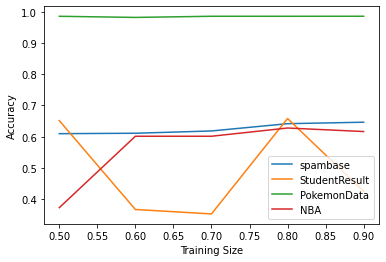

In [6]:
# Accuracy 
plt.plot(train_size, metrics_RF_a[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_RF_a[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_RF_a[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_RF_a[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Accuracy")
plt.legend()

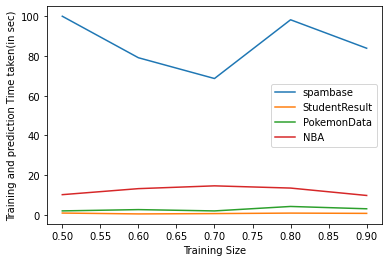

In [7]:
# Time taken 
plt.plot(train_size, metrics_RF_time[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_RF_time[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_RF_time[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_RF_time[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Training and prediction Time taken(in sec)")
plt.legend()

# 2) Adaboost

In [8]:
class AdaBoost:
  # defining the constructor
  def __init__(self):
    self.beta = [] # Hedge for each classifier
    self.predictions_of_classifier = [] # Prediction corresponding to each weak classifier
    self.result = [] # To store the final result corresponding to each item  

  # defining a function that would train each classifier
  # T -> Number of classifiers
  def train(self, dataset, total_classifier, trainsize): 
    # Splitting into X and Y
    X = dataset.iloc[:, :-1]
    Y = dataset.iloc[:, -1]
    # Number of rows in the dataset
    N = len(Y) 
    # Initializing the weight vector
    W = [1/N]*N
    # Initial Probabilities of distribution
    P = W[:]

    # Now executing the AdaBoost algorithm on each classifier
    for classifier_number in range(total_classifier):
      
      # Step-1: Updating the probability distribution
      P = [i/sum(W) for i in W]

      # Step-2: Here we would be requiring the predictions made by our Weak classifier
      # As beta updation will be error/(1-error)
      # For classifier to stop training we should get a good error of < 0.5
      # So classifier will be updated as long as error > 0.5 that is beta>=1
      beta = sys.maxsize
      y_pred = []

      while beta >=1:
        # Training and Prediction 
        weak_classifier_model = LogisticRegression()
        # Finding the indexes having high probability/weights        
        # Considering only 70% of total dataset for training
        seventy_percent_size = int(trainsize*N)
        high_weight_indexes = np.random.choice(N, size=seventy_percent_size, replace=False, p=P)
        required_data = dataset.loc[dataset.index[high_weight_indexes]]
        train_X = required_data.iloc[:, :-1]
        train_Y = required_data.iloc[:, -1]
        #train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=0.7)
        
        # Training of weak classifier
        weak_classifier_model.fit(train_X, train_Y)
        # Prediction on whole dataset
        y_pred = weak_classifier_model.predict(X)
        
        eta = 0
        # Step-3: error calculation and multiplying with probability and finding eta by summing all
        eta = sum([P[i]*abs(y_pred[i] - Y[i]) for i in range(N)])
        
        # Step-4: Updating beta
        beta = eta/(1-eta)      

      # Handling values of beta
      # Zero beta gives divide by zero exception as seen in the assignment
      # So we'll give small beta from our side
      if beta == 0:
        beta = 0.00000001
      # Storing values of beta and predictions of classifier for end result
      self.beta.append(beta)
      self.predictions_of_classifier.append(y_pred)

      # Step-5: Updating weights for next classifier
      W = [W[i]*beta**(1 - abs(y_pred[i] - Y[i])) for i in range(N)]

    # Preparation for output hypothesis
    # Below code has been taken from the assignment
    log_reciprocal_beta = [math.log(1/i) for i in self.beta]
    # Storing values for left side of the hypothesis equation
    left_sum_h_b = []
    for i in range(total_classifier):
      beta_mul = log_reciprocal_beta[i]
      pred_mul = self.predictions_of_classifier[i]
      temp_mul = [j*beta_mul for j in pred_mul]

      # Checking if left_sum_h_b is empty
      if len(left_sum_h_b) < 1:
        left_sum_h_b = temp_mul
      else:
        for m in range(len(temp_mul)):
          left_sum_h_b[m] += temp_mul[m]

    # Calculation for output of hypothesis:
    right = sum(log_reciprocal_beta)

    for i in range(len(left_sum_h_b)):
      if left_sum_h_b[i] >= (0.5*right):
        self.result.append(1)
      else:
        self.result.append(0)

  # Outputting the hypothesis
  def output_hypothesis(self, item):
    return self.result[item]


In [9]:
data_names = ['spambase.csv', 'Iris.csv', 'StudentResult.csv', 'PokemonData.csv', 'NBA.csv']
train_size = [.5, .6, .7, .8, .9]

metrics_Ada_a = []
metrics_Ada_p = []
metrics_Ada_r = []
metrics_Ada_f = []
metrics_Ada_time = []


for dataName in data_names:
  data_path = 'Data/' + dataName 
  

  metr_a = []
  metr_p = []
  metr_r = []
  metr_f = []
  metr_time = []

  for size in train_size:
    start = time.time()
    # Adaboost
    df = pd.read_csv(data_path)
    dataset = df
    adaBoost = AdaBoost()
    # q is the number of classifiers we want
    q=3
    adaBoost.train(dataset,q, size)
    y_pred = np.array([adaBoost.output_hypothesis(n) for n in range(len(dataset))])
    end = time.time()
    Y_test = df.iloc[:, -1]

    # Finding evaluation metrics
    a = accuracy_score(y_pred, Y_test)
    p = precision_score(y_pred, Y_test)
    r = recall_score(y_pred, Y_test)
    f = f1_score(y_pred, Y_test)
    
    metr_a.append(a)
    metr_p.append(p)
    metr_r.append(r)
    metr_f.append(f)
    metr_time.append(end-start)

  metrics_Ada_a.append(metr_a)
  metrics_Ada_p.append(metr_p)
  metrics_Ada_r.append(metr_r)
  metrics_Ada_f.append(metr_f)
  metrics_Ada_time.append(metr_time)

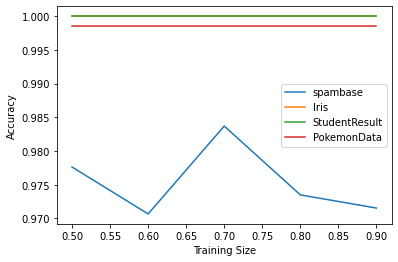

In [10]:
# Accuracy 
plt.plot(train_size, metrics_Ada_a[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_Ada_a[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_Ada_a[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_Ada_a[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Accuracy")
plt.legend()

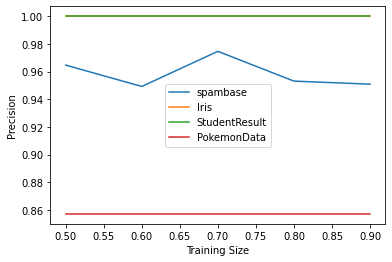

In [11]:
# Precision 
plt.plot(train_size, metrics_Ada_p[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_Ada_p[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_Ada_p[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_Ada_p[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Precision")
plt.legend()

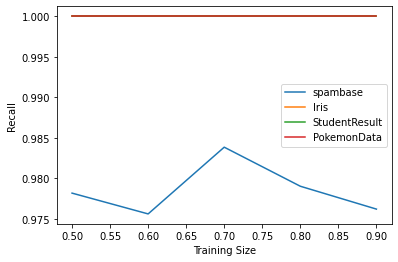

In [12]:
# Recall 
plt.plot(train_size, metrics_Ada_r[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_Ada_r[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_Ada_r[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_Ada_r[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Recall")
plt.legend()

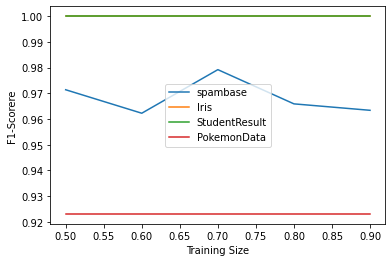

In [13]:
# F1-Score 
plt.plot(train_size, metrics_Ada_f[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_Ada_f[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_Ada_f[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_Ada_f[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("F1-Scorere")
plt.legend()

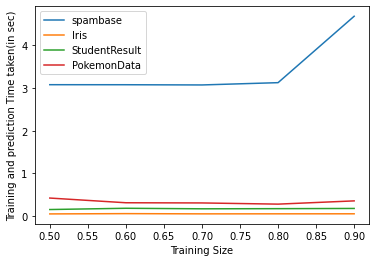

In [14]:
# Time taken 
plt.plot(train_size, metrics_Ada_time[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_Ada_time[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_Ada_time[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_Ada_time[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Training and prediction Time taken(in sec)")
plt.legend()

# 3) Borda Voting

In [18]:
def BordaVoting(data, trainsize):
  dataset = pd.read_csv(data)
  X = dataset.iloc[:, :-1]
  Y = dataset.iloc[:, -1]
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = trainsize)

  # Logistic Model
  logistic_model = LogisticRegression()
  logistic_model.fit(X_train, Y_train)
  logistic_probability_of_outcomes = logistic_model.predict_proba(X_test)

  # Ranking of outcome
  logistic_rank_0 = []
  logistic_rank_1 = []
  for i in logistic_probability_of_outcomes:
    if i[0] > i[1]:
      logistic_rank_0.append(2)
      logistic_rank_1.append(1)
    else:
      logistic_rank_0.append(1)
      logistic_rank_1.append(2)

  # Decision Tree classifier using gini index
  DC_gini_model = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3)
  DC_gini_model.fit(X_train, Y_train)
  DC_gini_probability_of_outcomes = DC_gini_model.predict_proba(X_test)

  # Ranking of outcome
  DC_gini_rank_0 = []
  DC_gini_rank_1 = []
  for i in DC_gini_probability_of_outcomes:
    if i[0] > i[1]:
      DC_gini_rank_0.append(2)
      DC_gini_rank_1.append(1)
    else:
      DC_gini_rank_0.append(1)
      DC_gini_rank_1.append(2)

  # Decision Tree classifier using entropy
  DC_entropy_model = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3)
  DC_entropy_model.fit(X_train, Y_train)
  DC_entropy_probability_of_outcomes = DC_entropy_model.predict_proba(X_test)

  # Ranking of outcome
  DC_entropy_rank_0 = []
  DC_entropy_rank_1 = []
  for i in DC_entropy_probability_of_outcomes:
    if i[0] > i[1]:
      DC_entropy_rank_0.append(2)
      DC_entropy_rank_1.append(1)
    else:
      DC_entropy_rank_0.append(1)
      DC_entropy_rank_1.append(2)

  '''
  # Neural network
  X_NN = np.array(X_train)
  Y_NN = Y_train
  X_NN_test = np.array(X_test)

  # Input Neurons
  input_neuron = dataset.shape[1]

  # build a model
  NN_model = Sequential()
  NN_model.add(Dense(input_neuron, input_shape=(X_NN.shape[1],), activation='relu'))
  NN_model.add(Dense(input_neuron, activation='relu'))
  NN_model.add(Dense(1, activation='sigmoid'))


  # Model Compilation
  NN_model.compile(optimizer='Adam', 
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # Model training
  NN_model.fit(X_NN,
            Y_NN,
            epochs=80, # you can set this to a big number!
            batch_size=10,
            validation_split=0.2,
            shuffle=True,
            verbose=0)

  # Model prediction
  neural_network_prediction = NN_model.predict(X_NN_test)

  # Ranking of outcome
  nn_classify_rank_0 = []
  nn_classify_rank_1 = []

  for i in neural_network_prediction:
    if i>0.5:
      nn_classify_rank_0.append(1)
      nn_classify_rank_1.append(2)
    else:
      nn_classify_rank_0.append(2)
      nn_classify_rank_1.append(1)
      '''

  # Overall rank across all the models
  zeros = []
  ones = []

  for i in range(len(Y_test)):
    zeros.append(logistic_rank_0[i] + DC_gini_rank_0[i] + DC_entropy_rank_0[i] )
    ones.append(logistic_rank_1[i] + DC_gini_rank_1[i] + DC_entropy_rank_1[i] )

  # Final prediction results
  y_pred = []

  for i, j in zip(zeros, ones):
    if i>j:
      y_pred.append(0)
    else:
      y_pred.append(1)

  
  # Finding evaluation metrics
  accuracy = accuracy_score(y_pred, Y_test)
  precision = precision_score(y_pred, Y_test)
  recall = recall_score(y_pred, Y_test)
  f1score = f1_score(y_pred, Y_test)
  return(accuracy, precision, recall, f1score)

In [19]:
data_names = ['spambase.csv', 'Iris.csv', 'StudentResult.csv', 'PokemonData.csv', 'NBA.csv']
train_size = [.5, .6, .7, .8, .9]

metrics_BV_a = []
metrics_BV_p = []
metrics_BV_r = []
metrics_BV_f = []
metrics_BV_time = []

for dataName in data_names:
  data_path = 'Data/' + dataName 
  metr_a = []
  metr_p = []
  metr_r = []
  metr_f = []
  metr_time = []

  for size in train_size:
    start = time.time()
    # Borda Voting
    a, p, r, f  = BordaVoting(data_path, size)
    end = time.time()
    metr_a.append(a)
    metr_p.append(p)
    metr_r.append(r)
    metr_f.append(f)
    metr_time.append(end-start)

  metrics_BV_a.append(metr_a)
  metrics_BV_p.append(metr_p)
  metrics_BV_r.append(metr_r)
  metrics_BV_f.append(metr_f)
  metrics_BV_time.append(metr_time)

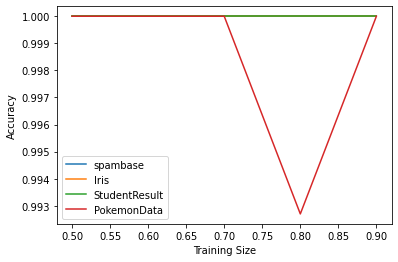

In [21]:
# Accuracy 
plt.plot(train_size, metrics_BV_a[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_BV_a[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_BV_a[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_BV_a[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Accuracy")
plt.legend()

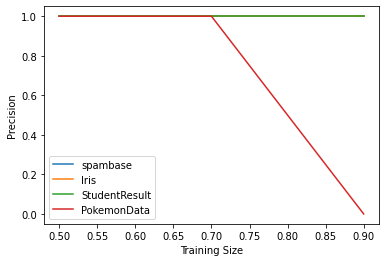

In [22]:
# Precision 
plt.plot(train_size, metrics_BV_p[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_BV_p[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_BV_p[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_BV_p[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Precision")
plt.legend()

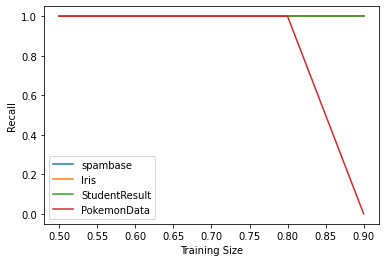

In [23]:
# Recall 
plt.plot(train_size, metrics_BV_r[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_BV_r[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_BV_r[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_BV_r[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Recall")
plt.legend()

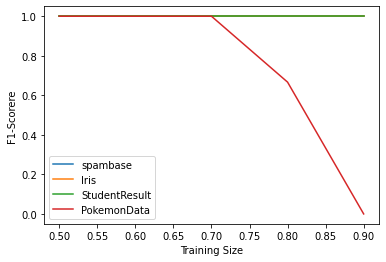

In [24]:
# F1-Score 
plt.plot(train_size, metrics_BV_f[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_BV_f[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_BV_f[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_BV_f[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("F1-Scorere")
plt.legend()

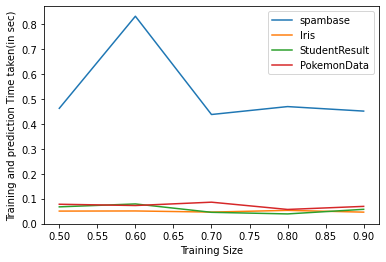

In [25]:
# Time taken 
plt.plot(train_size, metrics_BV_time[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_BV_time[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_BV_time[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_BV_time[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Training and prediction Time taken(in sec)")
plt.legend()

# 4) Stacked Generalization

In [26]:
# Logistic Model
def classifier_logistic_model(X_train, Y_train, X_test):
  logistic_model = LogisticRegression()
  logistic_model.fit(X_train, Y_train)
  logistic_probability_of_outcomes = logistic_model.predict(X_test)
  return(list(logistic_probability_of_outcomes))

# Decision Tree classifier using gini index
def classifier_gini_DT(X_train, Y_train, X_test):
  DC_gini_model = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3)
  DC_gini_model.fit(X_train, Y_train)
  DC_gini_probability_of_outcomes = DC_gini_model.predict(X_test)
  return(list(DC_gini_probability_of_outcomes))

# Decision Tree classifier using entropy
def classifier_entropy_DT(X_train, Y_train, X_test):
  DC_entropy_model = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3)
  DC_entropy_model.fit(X_train, Y_train)
  DC_entropy_probability_of_outcomes = DC_entropy_model.predict(X_test)
  return(list(DC_entropy_probability_of_outcomes))

# Neural network
def classifier_NN(X_train, Y_train, X_test):
  X_NN = np.array(X_train)
  Y_NN = Y_train
  X_NN_test = np.array(X_test)

  # Input Neurons
  input_neuron = X_train.shape[1]

  # build a model
  NN_model = Sequential()
  NN_model.add(Dense(input_neuron, input_shape=(X_NN.shape[1],), activation='relu'))
  NN_model.add(Dense(input_neuron, activation='relu'))
  NN_model.add(Dense(1, activation='sigmoid'))


  # Model Compilation
  NN_model.compile(optimizer='Adam', 
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # Model training
  NN_model.fit(X_NN,
            Y_NN,
            epochs=20, # you can set this to a big number!
            batch_size=10,
            validation_split=0.2,
            shuffle=True,
            verbose=0)

  # Model prediction
  neural_network_prediction = NN_model.predict(X_NN_test)
  result = []
  for i in neural_network_prediction:
    if i>0.5:
      result.append(1)
    else:
      result.append(0)
  return(result)

In [29]:
# Stacked Generalization method
def Stacked_Generalization(data, no_of_models=5, trainsize=.7):

  dataset = pd.read_csv(data)
  X = dataset.iloc[:, :-1]
  Y = dataset.iloc[:, -1]
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = trainsize)
  X_train.index = range(len(X_train))

  # If rows in training set is even
  if X_train.shape[0] % 2 == 0:
    N = X_train.shape[0]
  else: # Odd
    N = X_train.shape[0]-1

  # Function to find the division of data into different number of folds
  def k_fold(k):
    breaking_points = list(range(0, N, int(N/k)))[:-1]
    return(breaking_points, int(N/k))
  indexes, threshold = k_fold(no_of_models)

  # Lists to store the output of different classifiers for aggregator model
  logistic_outcome = []
  DT_gini_outcome = []
  DT_entropy_outcome = []
  NN_outcome = []
  Y_outcome = []

  # Splitting data into k folds train-test
  for i in range(len(indexes)):
    # Evaluating indexes to be involved in train and test
    test_index = i
    temp_indexes = list(range(len(indexes)))
    temp_indexes.remove(test_index)
    train_indexes = temp_indexes
    
    # Row indexes from X_train for test data to be considered
    test_indexes_rows = list(range(indexes[test_index], indexes[test_index] + threshold))

    # Row indexes from X_train for train data to be considered
    train_indexes_rows = []
    for ind in train_indexes:
      train_indexes_rows += list(range(indexes[ind], indexes[ind] + threshold))
    # Train X Data
    required_Xtrain_data = X_train.loc[X_train.index[train_indexes_rows]]
    # Test X Data
    required_Xtest_data = X_train.loc[X_train.index[test_indexes_rows]]

    Y_temp = list(Y_train)

    # Train Y Data
    required_Ytrain_data = np.array([Y_temp[i] for i in train_indexes_rows]) 
    # Test Y Data
    required_Ytest_data = [Y_temp[i]  for i in test_indexes_rows]

    # Now running the classifiers
    logistic_outcome += classifier_logistic_model(required_Xtrain_data, required_Ytrain_data, required_Xtest_data)
    DT_gini_outcome += classifier_gini_DT(required_Xtrain_data, required_Ytrain_data, required_Xtest_data)
    DT_entropy_outcome += classifier_entropy_DT(required_Xtrain_data, required_Ytrain_data, required_Xtest_data)
    #NN_outcome += classifier_NN(required_Xtrain_data, required_Ytrain_data, required_Xtest_data)
    Y_outcome += required_Ytest_data

  # Creating a dataframe for Aggregator
  df_aggregator = pd.DataFrame()
  df_aggregator['Logistic'] = logistic_outcome
  df_aggregator['DTGini'] = DT_gini_outcome
  df_aggregator['DTEntropy'] = DT_entropy_outcome
  #df_aggregator['NN'] = NN_outcome
  df_aggregator['Target'] = Y_outcome

  # Aggregator Training
  agg_model = LogisticRegression()
  agg_model.fit(df_aggregator.iloc[:, :-1], df_aggregator.iloc[:, -1])

  # # Training the classifiers on whole training data, and final test data classification
  df_aggregator = pd.DataFrame()
  df_aggregator['Logistic'] = classifier_logistic_model(X_train, Y_train, X_test)
  df_aggregator['DTGini'] = classifier_gini_DT(X_train, Y_train, X_test)
  df_aggregator['DTEntropy'] = classifier_entropy_DT(X_train, Y_train, X_test)
  #df_aggregator['NN'] = classifier_NN(X_train, Y_train, X_test)
  df_aggregator['Target'] = list(Y_test)

  # Aggregator Classification
  y_pred = agg_model.predict(df_aggregator.iloc[:, :-1])

  # Finding evaluation metrics
  accuracy = accuracy_score(y_pred, Y_test)
  precision = precision_score(y_pred, Y_test)
  recall = recall_score(y_pred, Y_test)
  f1score = f1_score(y_pred, Y_test)
  return(accuracy, precision, recall, f1score)

In [32]:
data_names = ['spambase.csv', 'Iris.csv', 'StudentResult.csv', 'PokemonData.csv', 'NBA.csv']
train_size = [.5, .6, .7, .8, .9]

metrics_SG_a = []
metrics_SG_p = []
metrics_SG_r = []
metrics_SG_f = []
metrics_SG_time = []

for dataName in data_names:
  print(dataName)
  data_path = 'Data/' + dataName 
  metr_a = []
  metr_p = []
  metr_r = []
  metr_f = []
  metr_time = []

  for size in train_size:
    start = time.time()
    # Stacked Generalization
    # 3 is the number of models
    a, p, r, f = Stacked_Generalization(data_path, 3, size)
    end = time.time()
    metr_a.append(a)
    metr_p.append(p)
    metr_r.append(r)
    metr_f.append(f)
    metr_time.append(end-start)

  metrics_SG_a.append(metr_a)
  metrics_SG_p.append(metr_p)
  metrics_SG_r.append(metr_r)
  metrics_SG_f.append(metr_f)
  metrics_SG_time.append(metr_time)

spambase.csv
Iris.csv
StudentResult.csv
PokemonData.csv
NBA.csv


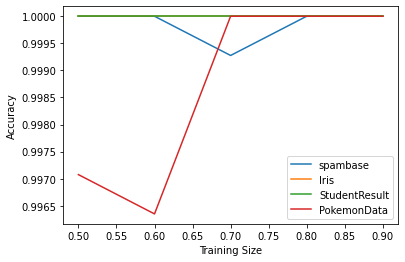

In [33]:
# Accuracy 
plt.plot(train_size, metrics_SG_a[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_SG_a[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_SG_a[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_SG_a[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Accuracy")
plt.legend()

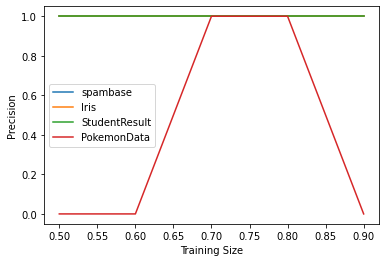

In [34]:
# Precision 
plt.plot(train_size, metrics_SG_p[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_SG_p[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_SG_p[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_SG_p[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Precision")
plt.legend()

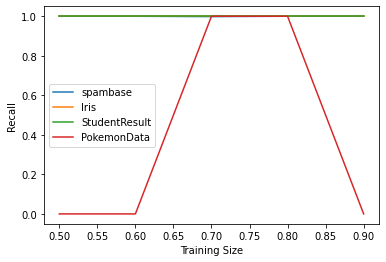

In [35]:
# Recall 
plt.plot(train_size, metrics_SG_r[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_SG_r[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_SG_r[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_SG_r[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Recall")
plt.legend()

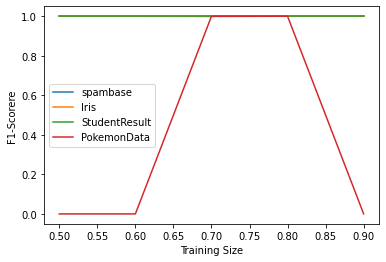

In [36]:
# F1-Score 
plt.plot(train_size, metrics_SG_f[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_SG_f[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_SG_f[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_SG_f[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("F1-Scorere")
plt.legend()

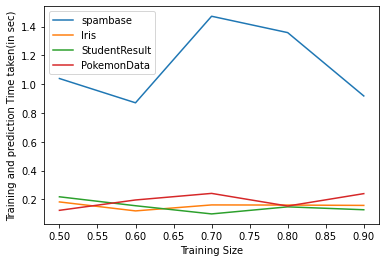

In [37]:
# Time taken 
plt.plot(train_size, metrics_SG_time[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_SG_time[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_SG_time[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_SG_time[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Training and prediction Time taken(in sec)")
plt.legend()

# 5) Learn++ (Random Subspace Ensemble)- Single model classifier

In [38]:
# Logistic Model
def classifier_logistic_model(X_train, Y_train, X_test):
  logistic_model = LogisticRegression()
  logistic_model.fit(X_train, Y_train)
  logistic_probability_of_outcomes = logistic_model.predict(X_test)
  return(list(logistic_probability_of_outcomes))

# Decision Tree classifier using gini index
def classifier_gini_DT(X_train, Y_train, X_test):
  DC_gini_model = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3)
  DC_gini_model.fit(X_train, Y_train)
  DC_gini_probability_of_outcomes = DC_gini_model.predict(X_test)
  return(list(DC_gini_probability_of_outcomes))

# Decision Tree classifier using entropy
def classifier_entropy_DT(X_train, Y_train, X_test):
  DC_entropy_model = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3)
  DC_entropy_model.fit(X_train, Y_train)
  DC_entropy_probability_of_outcomes = DC_entropy_model.predict(X_test)
  return(list(DC_entropy_probability_of_outcomes))

# Neural network
def classifier_NN(X_train, Y_train, X_test):
  X_NN = np.array(X_train)
  Y_NN = Y_train
  X_NN_test = np.array(X_test)

  # Input Neurons
  input_neuron = dataset.shape[1]

  # build a model
  NN_model = Sequential()
  NN_model.add(Dense(input_neuron, input_shape=(X_NN.shape[1],), activation='relu'))
  NN_model.add(Dense(input_neuron, activation='relu'))
  NN_model.add(Dense(1, activation='sigmoid'))


  # Model Compilation
  NN_model.compile(optimizer='Adam', 
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # Model training
  NN_model.fit(X_NN,
            Y_NN,
            epochs=20, # you can set this to a big number!
            batch_size=10,
            validation_split=0.2,
            shuffle=True,
            verbose=0)

  # Model prediction
  neural_network_prediction = NN_model.predict(X_NN_test)
  result = []
  for i in neural_network_prediction:
    if i>0.5:
      result.append(1)
    else:
      result.append(0)
  return(result)

In [39]:
# defining the learn++ algorithm function
# model_func is the classification function to be used for classification purpose
# number_of_features is the number of features to be slected randomly every time
# classification_times is the number of times different features would be selected
def learn_plus_pus(data, model_func, number_of_features, classification_times, trainsize):
  dataset = pd.read_csv(data)
  X = dataset.iloc[:, :-1]
  Y = dataset.iloc[:, -1]
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = trainsize)
  results = [[None]*classification_times]*(X_test.shape[0])

  features_length = X_train.shape[1]
  probs = [1/features_length]*features_length

  for ii in range(classification_times):
    # Selecting the indexes of the features based on their corresponding probability distribution
    high_weight_indexes = np.random.choice(features_length, size=number_of_features, replace=False, p=probs)
    # Reducing the weights of the features selected in above step
    for val in high_weight_indexes:
      probs[val] = probs[val]*(number_of_features/features_length)
    # Weights normalization
    weights_sum = sum(probs)
    probs = [i/weights_sum for i in probs]

    # Training and testig dataset after feature slected randomly
    training_x = X_train.iloc[:, high_weight_indexes]
    training_y = Y_train
    testing_x = X_test.iloc[:, high_weight_indexes]
    testing_y = Y_test
    
    # Classification and storing the results
    prediction_values = model_func(training_x, training_y, testing_x)

    for j in range(len(prediction_values)):
      results[j][ii] = prediction_values[j]

  def count_results(x):
    zeros = x.count(0)
    ones = x.count(1)
    if zeros > ones:
      return 0
    elif zeros < ones:
      return 1
    else:
      return(random.choice([0, 1]))

  y_pred = np.array([count_results(i) for i in results])

  # Finding evaluation metrics
  accuracy = accuracy_score(y_pred, Y_test)
  precision = precision_score(y_pred, Y_test)
  recall = recall_score(y_pred, Y_test)
  f1score = f1_score(y_pred, Y_test)
  return(accuracy, precision, recall, f1score)
  

In [40]:
data_names = ['spambase.csv', 'Iris.csv', 'StudentResult.csv', 'PokemonData.csv', 'NBA.csv']
train_size = [.5, .6, .7, .8, .9]

metrics_PPSM_a = []
metrics_PPSM_p = []
metrics_PPSM_r = []
metrics_PPSM_f = []
metrics_PPSM_time = []

for dataName in data_names:
  data_path = 'Data/' + dataName 
  metr_a = []
  metr_p = []
  metr_r = []
  metr_f = []
  metr_time = []

  for size in train_size:
    start = time.time()
    # Learn plus plus with single model
    models = [classifier_logistic_model, classifier_gini_DT, classifier_entropy_DT, classifier_NN]    
    a, p, r, f = learn_plus_pus(data_path, models[2], 5, 10, size)
    end = time.time()
    metr_a.append(a)
    metr_p.append(p)
    metr_r.append(r)
    metr_f.append(f)
    metr_time.append(end-start)

  metrics_PPSM_a.append(metr_a)
  metrics_PPSM_p.append(metr_p)
  metrics_PPSM_r.append(metr_r)
  metrics_PPSM_f.append(metr_f)
  metrics_PPSM_time.append(metr_time)

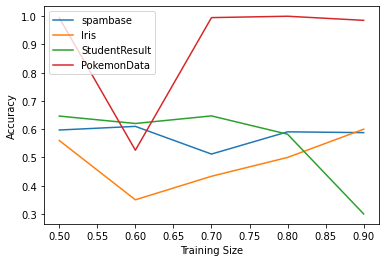

In [41]:
# Accuracy 
plt.plot(train_size, metrics_PPSM_a[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPSM_a[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPSM_a[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPSM_a[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Accuracy")
plt.legend()

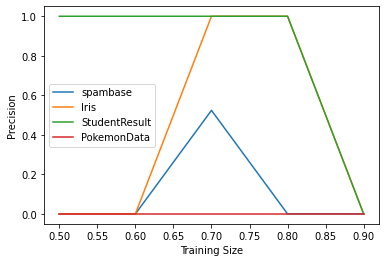

In [42]:
# Precision 
plt.plot(train_size, metrics_PPSM_p[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPSM_p[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPSM_p[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPSM_p[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Precision")
plt.legend()

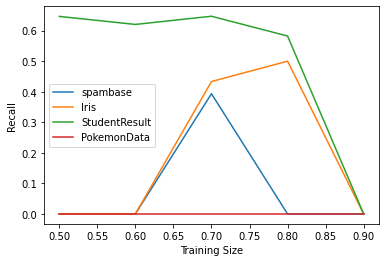

In [43]:
# Recall 
plt.plot(train_size, metrics_PPSM_r[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPSM_r[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPSM_r[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPSM_r[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Recall")
plt.legend()

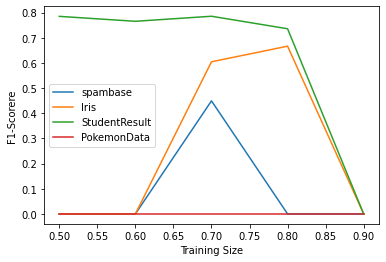

In [44]:
# F1-Score 
plt.plot(train_size, metrics_PPSM_f[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPSM_f[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPSM_f[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPSM_f[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("F1-Scorere")
plt.legend()

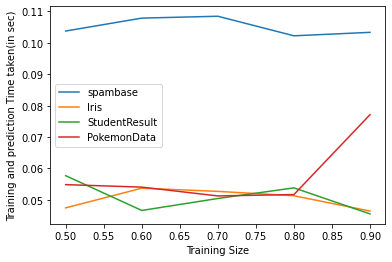

In [45]:
# Time taken 
plt.plot(train_size, metrics_PPSM_time[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPSM_time[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPSM_time[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPSM_time[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Training and prediction Time taken(in sec)")
plt.legend()

# CREATIVE ASPECT

# 6) Learn++ (Random Subspace Ensemble)- Random model selection for classification

In [46]:
# defining the learn++ algorithm function
# model_func is the classification function to be used for classification purpose
# number_of_features is the number of features to be slected randomly every time
# classification_times is the number of times different features would be selected
def learn_plus_pus_random(data, models, number_of_features, classification_times, trainsize):
  dataset = pd.read_csv(data)
  X = dataset.iloc[:, :-1]
  Y = dataset.iloc[:, -1]
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = trainsize)
  results = [[None]*classification_times]*(X_test.shape[0])

  features_length = X_train.shape[1]
  probs = [1/features_length]*features_length

  for ii in range(classification_times):
    # Selecting the indexes of the features based on their corresponding probability distribution
    high_weight_indexes = np.random.choice(features_length, size=number_of_features, replace=False, p=probs)
    # Reducing the weights of the features selected in above step
    for val in high_weight_indexes:
      probs[val] = probs[val]*(number_of_features/features_length)
    # Weights normalization
    weights_sum = sum(probs)
    probs = [i/weights_sum for i in probs]

    # Training and testig dataset after feature slected randomly
    training_x = X_train.iloc[:, high_weight_indexes]
    training_y = Y_train
    testing_x = X_test.iloc[:, high_weight_indexes]
    testing_y = Y_test
    
    # Classification and storing the results
    model_name = random.choice(models)
    prediction_values = model_name(training_x, training_y, testing_x)

    for j in range(len(prediction_values)):
      results[j][ii] = prediction_values[j]

  def count_results(x):
    zeros = x.count(0)
    ones = x.count(1)
    if zeros > ones:
      return 0
    elif zeros < ones:
      return 1
    else:
      return(random.choice([0, 1]))

  y_pred = np.array([count_results(i) for i in results])
  

  # Finding evaluation metrics
  accuracy = accuracy_score(y_pred, Y_test)
  precision = precision_score(y_pred, Y_test)
  recall = recall_score(y_pred, Y_test)
  f1score = f1_score(y_pred, Y_test)
  return(accuracy, precision, recall, f1score)

In [48]:
data_names = ['spambase.csv', 'Iris.csv', 'StudentResult.csv', 'PokemonData.csv', 'NBA.csv']
train_size = [.5, .6, .7, .8, .9]

metrics_PPRM_a = []
metrics_PPRM_p = []
metrics_PPRM_r = []
metrics_PPRM_f = []
metrics_PPRM_time = []

for dataName in data_names:
  data_path = 'Data/' + dataName 
  metr_a = []
  metr_p = []
  metr_r = []
  metr_f = []
  metr_time = []

  for size in train_size:
    start = time.time()
    # Learn plus plys with random models
    models = [classifier_logistic_model, classifier_gini_DT, classifier_entropy_DT]
    a, p, r, f = learn_plus_pus_random(data_path, models, 5, 10, size)
    end = time.time()
    metr_a.append(a)
    metr_p.append(p)
    metr_r.append(r)
    metr_f.append(f)
    metr_time.append(end-start)

  metrics_PPRM_a.append(metr_a)
  metrics_PPRM_p.append(metr_p)
  metrics_PPRM_r.append(metr_r)
  metrics_PPRM_f.append(metr_f)
  metrics_PPRM_time.append(metr_time)

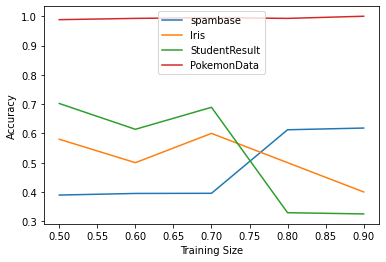

In [49]:
# Accuracy 
plt.plot(train_size, metrics_PPRM_a[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPRM_a[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPRM_a[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPRM_a[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Accuracy")
plt.legend()

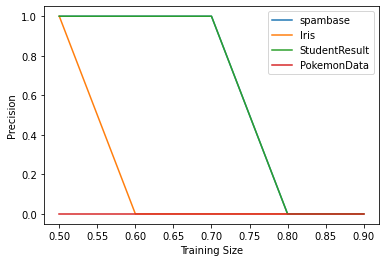

In [50]:
# Precision 
plt.plot(train_size, metrics_PPRM_p[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPRM_p[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPRM_p[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPRM_p[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Precision")
plt.legend()

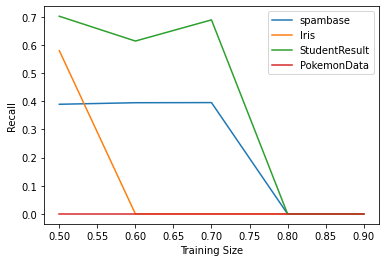

In [51]:
# Recall 
plt.plot(train_size, metrics_PPRM_r[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPRM_r[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPRM_r[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPRM_r[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Recall")
plt.legend()

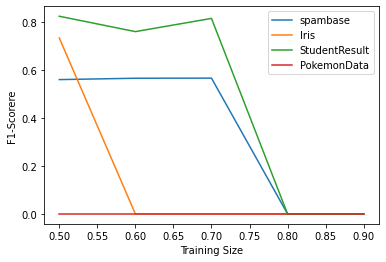

In [52]:
# F1-Score 
plt.plot(train_size, metrics_PPRM_f[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPRM_f[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPRM_f[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPRM_f[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("F1-Scorere")
plt.legend()

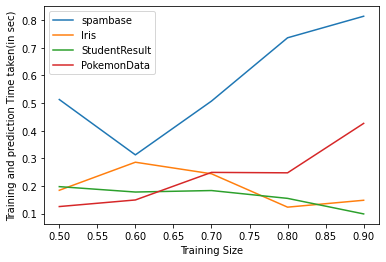

In [53]:
# Time taken 
plt.plot(train_size, metrics_PPRM_time[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPRM_time[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPRM_time[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPRM_time[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Training and prediction Time taken(in sec)")
plt.legend()

# 7) Combination of Learn++ and Borda Voting

In [54]:
def BordaVoting_model_func(training_x, training_y, testing_x, testing_y):
  X_train, Y_train, X_test, Y_test = training_x, training_y, testing_x, testing_y

  # Logistic Model
  logistic_model = LogisticRegression()
  logistic_model.fit(X_train, Y_train)
  logistic_probability_of_outcomes = logistic_model.predict_proba(X_test)

  # Ranking of outcome
  logistic_rank_0 = []
  logistic_rank_1 = []
  for i in logistic_probability_of_outcomes:
    if i[0] > i[1]:
      logistic_rank_0.append(2)
      logistic_rank_1.append(1)
    else:
      logistic_rank_0.append(1)
      logistic_rank_1.append(2)

  # Decision Tree classifier using gini index
  DC_gini_model = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3)
  DC_gini_model.fit(X_train, Y_train)
  DC_gini_probability_of_outcomes = DC_gini_model.predict_proba(X_test)

  # Ranking of outcome
  DC_gini_rank_0 = []
  DC_gini_rank_1 = []
  for i in DC_gini_probability_of_outcomes:
    if i[0] > i[1]:
      DC_gini_rank_0.append(2)
      DC_gini_rank_1.append(1)
    else:
      DC_gini_rank_0.append(1)
      DC_gini_rank_1.append(2)

  # Decision Tree classifier using entropy
  DC_entropy_model = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3)
  DC_entropy_model.fit(X_train, Y_train)
  DC_entropy_probability_of_outcomes = DC_entropy_model.predict_proba(X_test)

  # Ranking of outcome
  DC_entropy_rank_0 = []
  DC_entropy_rank_1 = []
  for i in DC_entropy_probability_of_outcomes:
    if i[0] > i[1]:
      DC_entropy_rank_0.append(2)
      DC_entropy_rank_1.append(1)
    else:
      DC_entropy_rank_0.append(1)
      DC_entropy_rank_1.append(2)

  '''
  # Neural network
  X_NN = np.array(X_train)
  Y_NN = Y_train
  X_NN_test = np.array(X_test)

  # Input Neurons
  input_neuron = X_train.shape[1]

  # build a model
  NN_model = Sequential()
  NN_model.add(Dense(input_neuron, input_shape=(X_NN.shape[1],), activation='relu'))
  NN_model.add(Dense(input_neuron, activation='relu'))
  NN_model.add(Dense(1, activation='sigmoid'))


  # Model Compilation
  NN_model.compile(optimizer='Adam', 
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # Model training
  NN_model.fit(X_NN,
            Y_NN,
            epochs=80, # you can set this to a big number!
            batch_size=10,
            validation_split=0.2,
            shuffle=True,
            verbose=0)

  # Model prediction
  neural_network_prediction = NN_model.predict(X_NN_test)

  # Ranking of outcome
  nn_classify_rank_0 = []
  nn_classify_rank_1 = []

  for i in neural_network_prediction:
    if i>0.5:
      nn_classify_rank_0.append(1)
      nn_classify_rank_1.append(2)
    else:
      nn_classify_rank_0.append(2)
      nn_classify_rank_1.append(1)

  '''

  # Overall rank across all the models
  zeros = []
  ones = []

  for i in range(len(Y_test)):
    zeros.append(logistic_rank_0[i] + DC_gini_rank_0[i] + DC_entropy_rank_0[i] )
    ones.append(logistic_rank_1[i] + DC_gini_rank_1[i] + DC_entropy_rank_1[i] )

  # Final prediction results
  y_pred = []

  for i, j in zip(zeros, ones):
    if i>j:
      y_pred.append(0)
    else:
      y_pred.append(1)

  return(y_pred)

In [55]:
# defining the learn++ algorithm function
# model_func is the classification function to be used for classification purpose
# number_of_features is the number of features to be slected randomly every time
# classification_times is the number of times different features would be selected
def learn_plus_plus_borda(data, number_of_features, classification_times, trainsize):
  dataset = pd.read_csv(data)
  X = dataset.iloc[:, :-1]
  Y = dataset.iloc[:, -1]
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = trainsize)
  results = [[None]*classification_times]*(X_test.shape[0])

  features_length = X_train.shape[1]
  probs = [1/features_length]*features_length

  for ii in range(classification_times):
    # Selecting the indexes of the features based on their corresponding probability distribution
    high_weight_indexes = np.random.choice(features_length, size=number_of_features, replace=False, p=probs)
    # Reducing the weights of the features selected in above step
    for val in high_weight_indexes:
      probs[val] = probs[val]*(number_of_features/features_length)
    # Weights normalization
    weights_sum = sum(probs)
    probs = [i/weights_sum for i in probs]

    # Training and testig dataset after feature slected randomly
    training_x = X_train.iloc[:, high_weight_indexes]
    training_y = Y_train
    testing_x = X_test.iloc[:, high_weight_indexes]
    testing_y = Y_test
    
    # Classification and storing the results
    prediction_values = BordaVoting_model_func(training_x, training_y, testing_x, Y_test)

    for j in range(len(prediction_values)):
      results[j][ii] = prediction_values[j]

  def count_results(x):
    zeros = x.count(0)
    ones = x.count(1)
    if zeros > ones:
      return 0
    elif zeros < ones:
      return 1
    else:
      return(random.choice([0, 1]))

  y_pred = np.array([count_results(i) for i in results])

  # Finding evaluation metrics
  accuracy = accuracy_score(y_pred, Y_test)
  precision = precision_score(y_pred, Y_test)
  recall = recall_score(y_pred, Y_test)
  f1score = f1_score(y_pred, Y_test)
  return(accuracy, precision, recall, f1score)
  

In [56]:
data_names = ['spambase.csv', 'Iris.csv', 'StudentResult.csv', 'PokemonData.csv', 'NBA.csv']
train_size = [.5, .6, .7, .8, .9]

metrics_PPB_a = []
metrics_PPB_p = []
metrics_PPB_r = []
metrics_PPB_f = []
metrics_PPB_time = []

for dataName in data_names:
  print(dataName)
  data_path = 'Data/' + dataName 
  metr_a = []
  metr_p = []
  metr_r = []
  metr_f = []
  metr_time = []

  for size in train_size:
    start = time.time()
    a, p, r, f = learn_plus_plus_borda(data_path, 4, 6, size)
    end = time.time()
    metr_a.append(a)
    metr_p.append(p)
    metr_r.append(r)
    metr_f.append(f)
    metr_time.append(end-start)

  metrics_PPB_a.append(metr_a)
  metrics_PPB_p.append(metr_p)
  metrics_PPB_r.append(metr_r)
  metrics_PPB_f.append(metr_f)
  metrics_PPB_time.append(metr_time)

spambase.csv
Iris.csv
StudentResult.csv
PokemonData.csv
NBA.csv


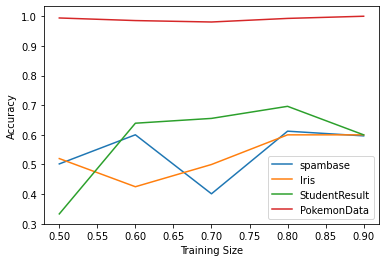

In [57]:
# Accuracy 
plt.plot(train_size, metrics_PPB_a[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPB_a[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPB_a[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPB_a[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Accuracy")
plt.legend()

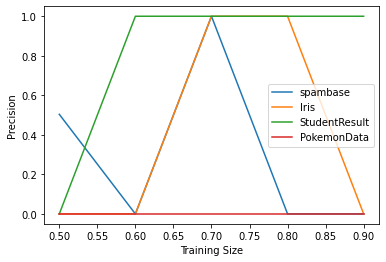

In [58]:
# Precision 
plt.plot(train_size, metrics_PPB_p[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPB_p[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPB_p[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPB_p[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Precision")
plt.legend()

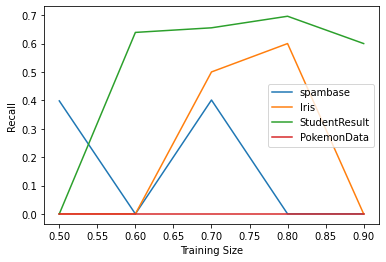

In [59]:
# Recall 
plt.plot(train_size, metrics_PPB_r[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPB_r[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPB_r[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPB_r[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Recall")
plt.legend()

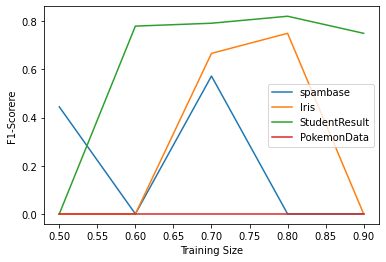

In [60]:
# F1-Score 
plt.plot(train_size, metrics_PPB_f[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPB_f[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPB_f[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPB_f[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("F1-Scorere")
plt.legend()

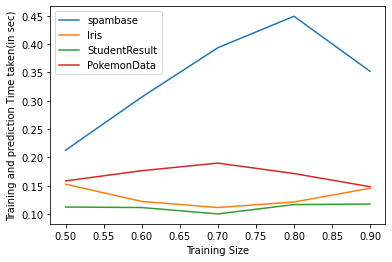

In [61]:
# Time taken 
plt.plot(train_size, metrics_PPB_time[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPB_time[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPB_time[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPB_time[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Training and prediction Time taken(in sec)")
plt.legend()

# 8) Combination of Learn++ and Stacked Generalization

In [62]:
# Stacked Generalization method
def Stacked_Generalization_model_func(training_x, training_y, testing_x, testing_y):
  X_train, Y_train, X_test, Y_test = training_x, training_y, testing_x, testing_y
  X_train.index = range(len(X_train))

  # If rows in training set is even
  if X_train.shape[0] % 2 == 0:
    N = X_train.shape[0]
  else: # Odd
    N = X_train.shape[0]-1

  # Function to find the division of data into different number of folds
  def k_fold(k):
    breaking_points = list(range(0, N, round(N/k)))[:-1]
    return(breaking_points, round(N/k))
  indexes, threshold = k_fold(5)

  # Lists to store the output of different classifiers for aggregator model
  logistic_outcome = []
  DT_gini_outcome = []
  DT_entropy_outcome = []
  Y_outcome = []

  # Splitting data into k folds train-test
  for i in range(len(indexes)):
    # Evaluating indexes to be involved in train and test
    test_index = i
    temp_indexes = list(range(len(indexes)))
    temp_indexes.remove(test_index)
    train_indexes = temp_indexes
    
    # Row indexes from X_train for test data to be considered
    test_indexes_rows = list(range(indexes[test_index], indexes[test_index] + threshold))

    # Row indexes from X_train for train data to be considered
    train_indexes_rows = []
    for ind in train_indexes:
      train_indexes_rows += list(range(indexes[ind], indexes[ind] + threshold))
    
    # Train X Data
    required_Xtrain_data = X_train.loc[X_train.index[train_indexes_rows]]
    # Test X Data
    required_Xtest_data = X_train.loc[X_train.index[test_indexes_rows]]

    Y_temp = list(Y_train)

    # Train Y Data
    required_Ytrain_data = np.array([Y_temp[i] for i in train_indexes_rows]) 
    # Test Y Data
    required_Ytest_data = [Y_temp[i]  for i in test_indexes_rows]

    # Now running the classifiers
    logistic_outcome += classifier_logistic_model(required_Xtrain_data, required_Ytrain_data, required_Xtest_data)
    DT_gini_outcome += classifier_gini_DT(required_Xtrain_data, required_Ytrain_data, required_Xtest_data)
    DT_entropy_outcome += classifier_entropy_DT(required_Xtrain_data, required_Ytrain_data, required_Xtest_data)
    Y_outcome += required_Ytest_data

  # Creating a dataframe for Aggregator
  df_aggregator = pd.DataFrame()
  df_aggregator['Logistic'] = logistic_outcome
  df_aggregator['DTGini'] = DT_gini_outcome
  df_aggregator['DTEntropy'] = DT_entropy_outcome
  df_aggregator['Target'] = Y_outcome

  # Aggregator Training
  agg_model = LogisticRegression()
  agg_model.fit(df_aggregator.iloc[:, :-1], df_aggregator.iloc[:, -1])

  # # Training the classifiers on whole training data, and final test data classification
  df_aggregator = pd.DataFrame()
  df_aggregator['Logistic'] = classifier_logistic_model(X_train, Y_train, X_test)
  df_aggregator['DTGini'] = classifier_gini_DT(X_train, Y_train, X_test)
  df_aggregator['DTEntropy'] = classifier_entropy_DT(X_train, Y_train, X_test)
  df_aggregator['Target'] = list(Y_test)

  # Aggregator Classification
  agg_model_prediction = agg_model.predict(df_aggregator.iloc[:, :-1])

  return(agg_model_prediction)

In [63]:
# defining the learn++ algorithm function
# model_func is the classification function to be used for classification purpose
# number_of_features is the number of features to be slected randomly every time
# classification_times is the number of times different features would be selected
def learn_plus_plus_SG(data, number_of_features, classification_times, trainsize):
  dataset = pd.read_csv(data)
  X = dataset.iloc[:, :-1]
  Y = dataset.iloc[:, -1]
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = trainsize)
  results = [[None]*classification_times]*(X_test.shape[0])

  features_length = X_train.shape[1]
  probs = [1/features_length]*features_length

  for ii in range(classification_times):
    # Selecting the indexes of the features based on their corresponding probability distribution
    high_weight_indexes = np.random.choice(features_length, size=number_of_features, replace=False, p=probs)
    # Reducing the weights of the features selected in above step
    for val in high_weight_indexes:
      probs[val] = probs[val]*(number_of_features/features_length)
    # Weights normalization
    weights_sum = sum(probs)
    probs = [i/weights_sum for i in probs]

    # Training and testig dataset after feature slected randomly
    training_x = X_train.iloc[:, high_weight_indexes]
    training_y = Y_train
    testing_x = X_test.iloc[:, high_weight_indexes]
    testing_y = Y_test
    
    # Classification and storing the results
    prediction_values = Stacked_Generalization_model_func(training_x, training_y, testing_x, Y_test)

    for j in range(len(prediction_values)):
      results[j][ii] = prediction_values[j]

  def count_results(x):
    zeros = x.count(0)
    ones = x.count(1)
    if zeros > ones:
      return 0
    elif zeros < ones:
      return 1
    else:
      return(random.choice([0, 1]))

  y_pred = np.array([count_results(i) for i in results])
  
  # Finding evaluation metrics
  accuracy = accuracy_score(y_pred, Y_test)
  precision = precision_score(y_pred, Y_test)
  recall = recall_score(y_pred, Y_test)
  f1score = f1_score(y_pred, Y_test)
  return(accuracy, precision, recall, f1score)

In [64]:
data_names = ['spambase.csv', 'Iris.csv', 'StudentResult.csv', 'PokemonData.csv', 'NBA.csv']
train_size = [.5, .6, .7, .8, .9]

metrics_PPSG_a = []
metrics_PPSG_p = []
metrics_PPSG_r = []
metrics_PPSG_f = []
metrics_PPSG_time = []

for dataName in data_names:
  data_path = 'Data/' + dataName 
  metr_a = []
  metr_p = []
  metr_r = []
  metr_f = []
  metr_time = []

  for size in train_size:
    start = time.time()

    # Learn plus plus SG
    a, p, r, f = learn_plus_plus_SG(data_path, 5, 10, size)
    end = time.time()
    metr_a.append(a)
    metr_p.append(p)
    metr_r.append(r)
    metr_f.append(f)
    metr_time.append(end-start)

  metrics_PPSG_a.append(metr_a)
  metrics_PPSG_p.append(metr_p)
  metrics_PPSG_r.append(metr_r)
  metrics_PPSG_f.append(metr_f)
  metrics_PPSG_time.append(metr_time)

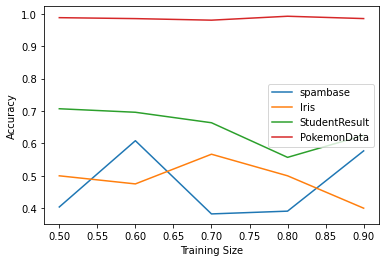

In [65]:
# Accuracy 
plt.plot(train_size, metrics_PPSG_a[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPSG_a[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPSG_a[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPSG_a[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Accuracy")
plt.legend()

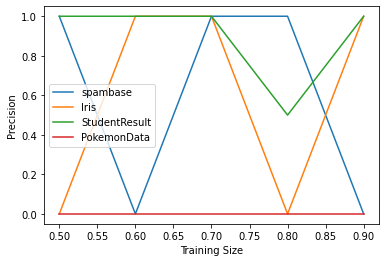

In [66]:
# Precision 
plt.plot(train_size, metrics_PPSG_p[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPSG_p[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPSG_p[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPSG_p[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Precision")
plt.legend()

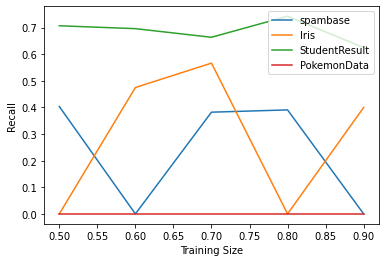

In [67]:
# Recall 
plt.plot(train_size, metrics_PPSG_r[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPSG_r[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPSG_r[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPSG_r[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Recall")
plt.legend()

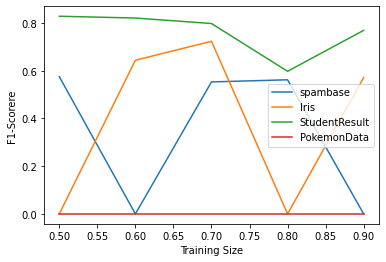

In [68]:
# F1-Score 
plt.plot(train_size, metrics_PPSG_f[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPSG_f[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPSG_f[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPSG_f[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("F1-Scorere")
plt.legend()

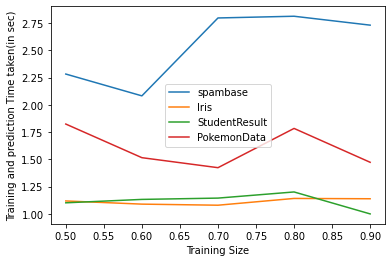

In [69]:
# Time taken 
plt.plot(train_size, metrics_PPSG_time[0] , label = data_names[0][:-4])
plt.plot(train_size, metrics_PPSG_time[1] , label = data_names[1][:-4])
plt.plot(train_size, metrics_PPSG_time[2] , label = data_names[2][:-4])
plt.plot(train_size, metrics_PPSG_time[3] , label = data_names[3][:-4])

plt.xlabel('Training Size')
plt.ylabel("Training and prediction Time taken(in sec)")
plt.legend()

# Combined comparison

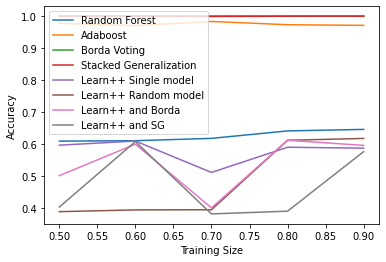

In [70]:
# data_names = ['spambase.csv', 'Iris.csv', 'StudentResult.csv', 'PokemonData.csv', 'NBA.csv']
train_size = [.5, .6, .7, .8, .9]

# Accuracy for Large Dataset- Spambase
plt.plot(train_size, metrics_RF_a[0] , label = 'Random Forest')
plt.plot(train_size, metrics_Ada_a[0] , label = 'Adaboost')
plt.plot(train_size, metrics_BV_a[0] , label = 'Borda Voting')
plt.plot(train_size, metrics_SG_a[0] , label = 'Stacked Generalization')
plt.plot(train_size, metrics_PPSM_a[0] , label = 'Learn++ Single model')
plt.plot(train_size, metrics_PPRM_a[0] , label = 'Learn++ Random model')
plt.plot(train_size, metrics_PPB_a[0] , label = 'Learn++ and Borda')
plt.plot(train_size, metrics_PPSG_a[0] , label = 'Learn++ and SG')

plt.xlabel('Training Size')
plt.ylabel("Accuracy")
plt.legend()

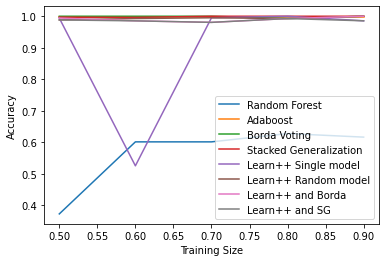

In [71]:
# Accuracy for Large Dataset- Pokemon
plt.plot(train_size, metrics_RF_a[3] , label = 'Random Forest')
plt.plot(train_size, metrics_Ada_a[3] , label = 'Adaboost')
plt.plot(train_size, metrics_BV_a[3] , label = 'Borda Voting')
plt.plot(train_size, metrics_SG_a[3] , label = 'Stacked Generalization')
plt.plot(train_size, metrics_PPSM_a[3] , label = 'Learn++ Single model')
plt.plot(train_size, metrics_PPRM_a[3] , label = 'Learn++ Random model')
plt.plot(train_size, metrics_PPB_a[3] , label = 'Learn++ and Borda')
plt.plot(train_size, metrics_PPSG_a[3] , label = 'Learn++ and SG')

plt.xlabel('Training Size')
plt.ylabel("Accuracy")
plt.legend()

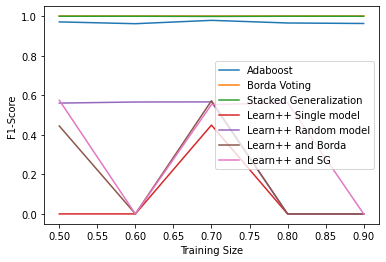

In [74]:
# f1-score for Large Dataset- Spambase
plt.plot(train_size, metrics_Ada_f[0] , label = 'Adaboost')
plt.plot(train_size, metrics_BV_f[0] , label = 'Borda Voting')
plt.plot(train_size, metrics_SG_f[0] , label = 'Stacked Generalization')
plt.plot(train_size, metrics_PPSM_f[0] , label = 'Learn++ Single model')
plt.plot(train_size, metrics_PPRM_f[0] , label = 'Learn++ Random model')
plt.plot(train_size, metrics_PPB_f[0] , label = 'Learn++ and Borda')
plt.plot(train_size, metrics_PPSG_f[0] , label = 'Learn++ and SG')

plt.xlabel('Training Size')
plt.ylabel("F1-Score")
plt.legend()

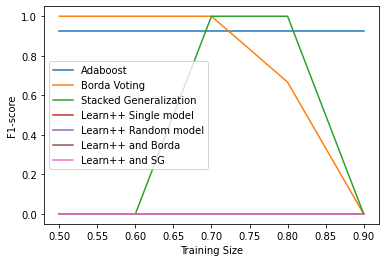

In [75]:
# f1-score for Large Dataset- Pokemon
plt.plot(train_size, metrics_Ada_f[3] , label = 'Adaboost')
plt.plot(train_size, metrics_BV_f[3] , label = 'Borda Voting')
plt.plot(train_size, metrics_SG_f[3] , label = 'Stacked Generalization')
plt.plot(train_size, metrics_PPSM_f[3] , label = 'Learn++ Single model')
plt.plot(train_size, metrics_PPRM_f[3] , label = 'Learn++ Random model')
plt.plot(train_size, metrics_PPB_f[3] , label = 'Learn++ and Borda')
plt.plot(train_size, metrics_PPSG_f[3] , label = 'Learn++ and SG')

plt.xlabel('Training Size')
plt.ylabel("F1-score")
plt.legend()